In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna
import gc

from sklearn.metrics import roc_auc_score, f1_score
from IPython.display import clear_output

from joblib import load
from tqdm import trange
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import StratifiedKFold

from sparse_vector.sparse_vector import SparseVector

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Data loading

In [2]:
chrom_names = [f'chr{i}' for i in list(range(1, 23)) + ['X', 'Y']]
feature_names = [i[:-4] for i in os.listdir('./data_hg_38/features/sparse/stem_cells') 
                 if i.endswith(".pkl") and not "G-quadruplex" in i]

In [3]:
def chrom_reader(chrom):
    files = sorted([i for i in os.listdir(f'./data_hg_38/dna/') if f"{chrom}_" in i])
    return ''.join([load(f"./data_hg_38/dna/{file}") for file in files])

In [4]:
DNA = {chrom:chrom_reader(chrom) for chrom in tqdm(chrom_names)}
G4 = load('./data_hg_38/targets/sparse/g4.pkl')

DNA_features = {feature: load(f'./data_hg_38/features/sparse/stem_cells/{feature}.pkl')
                for feature in tqdm(feature_names)}

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/321 [00:00<?, ?it/s]

# Dataset class

In [5]:
from torch.utils import data

class Dataset(data.Dataset):
    def __init__(self, chroms, features,
                 dna_source, features_source,
                 labels_source, intervals, max_omics_value = 1000):
        self.chroms = chroms
        self.features = features
        self.dna_source = dna_source
        self.features_source = features_source
        self.labels_source = labels_source
        self.intervals = intervals
        self.le = LabelBinarizer().fit(np.array([["A"], ["C"], ["T"], ["G"]]))
        self.max_omics_value = max_omics_value

    def __len__(self):
        return len(self.intervals)

    def __getitem__(self, index):
        interval = self.intervals[index]
        chrom = interval[0]
        begin = int(interval[1])
        end = int(interval[2])
        dna_OHE = self.le.transform(list(self.dna_source[chrom][begin:end].upper()))

        feature_matr = []
        for feature in self.features:
            source = self.features_source[feature]
            if chrom in source:
                if self.max_omics_value == 1:
                    feature_matr.append(np.ones(end-begin, dtype=np.float32))
                else:
                    feature_matr.append(source[chrom][begin:end])
            else:
                feature_matr.append(np.zeros(end-begin, dtype=np.float32))
        if len(feature_matr) > 0:
            X = np.hstack((dna_OHE, np.array(feature_matr).T/self.max_omics_value)).astype(np.float32)
        else:
            X = dna_OHE.astype(np.float32)
        y = self.labels_source[interval[0]][interval[1]: interval[2]]

        return (X, y)

# Data selection

In [6]:
def get_train_test_data(width, max_omics_value=1000):
    np.random.seed(10)
    
    ints_in = []
    ints_out = []

    for chrm in chrom_names:
        for st in range(0, G4[chrm].shape - width, width):
            interval = [st, min(st + width, G4[chrm].shape)]
            if G4[chrm][interval[0]: interval[1]].any():
                ints_in.append([chrm, interval[0], interval[1]])
            else:
                ints_out.append([chrm, interval[0], interval[1]])

    ints_in = np.array(ints_in)
    ints_out = np.array(ints_out)[np.random.choice(range(len(ints_out)), size=len(ints_in) * 3, replace=False)]
    
    np.random.seed(42)
    equalized = np.vstack((ints_in, ints_out))
    equalized = [[inter[0], int(inter[1]), int(inter[2])] for inter in equalized]
    
    train_inds, test_inds = next(StratifiedKFold().split(equalized, [elem[0] for elem in equalized]))
    train_intervals, test_intervals = [equalized[i] for i in train_inds], [equalized[i] for i in test_inds]
    
    np.random.seed(42)
    params = {'batch_size': 32,
              'num_workers':16,
              'shuffle':True}
    
    train_dataset = Dataset(chrom_names, feature_names, 
                           DNA, DNA_features, 
                           G4, train_intervals, 
                           max_omics_value = max_omics_value)
    
    test_dataset = Dataset(chrom_names, feature_names, 
                           DNA, DNA_features, 
                           G4, test_intervals,
                           max_omics_value = max_omics_value)
    
    loader_train = data.DataLoader(train_dataset, **params)
    loader_test = data.DataLoader(test_dataset, **params)
    
    return loader_train, loader_test

# Train and test

In [7]:
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from IPython.display import clear_output
import time
from copy import deepcopy

In [8]:
def loss_func(output, y_batch):
    return torch.nn.NLLLoss()(torch.transpose(output, 2, 1), y_batch)

def train_epoch(model, optimizer):
    roc_auc_log, precision_log, recall_log, f1_log, acc_log, loss_log = [], [], [], [], [], []
    model.train()
    for X_batch, y_batch in loader_train:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).long()
        optimizer.zero_grad()
        output = model(X_batch)
        if output.dim() == 2:  
            output = output.unsqueeze(0)  
        pred = torch.argmax(output, dim=2)
        with torch.no_grad():
            y_pred = nn.Softmax(dim=1)(output)[:, :,1].cpu().numpy().flatten()
            if np.std(y_batch.cpu().numpy().flatten()) == 0:
                roc_auc = 0
                precision = 0
                recall = 0
            else:
                roc_auc = roc_auc_score(y_batch.cpu().numpy().flatten(),
                                        y_pred)

                precision = precision_score(y_batch.cpu().numpy().flatten(), pred.cpu().numpy().flatten(), zero_division=0)
                recall = recall_score(y_batch.cpu().numpy().flatten(), pred.cpu().numpy().flatten())
                
            precision_log.append(precision)
            recall_log.append(recall)             
            f1_log.append(f1_score(y_batch.cpu().numpy().flatten(),
                             pred.cpu().numpy().flatten(), zero_division=0))

        roc_auc_log.append(roc_auc)
        acc = torch.mean((pred.to(device) == y_batch).float())
        acc_log.append(acc.cpu().numpy())
        loss = loss_func(output, y_batch)
        loss.backward()
        optimizer.step()
        
        loss = loss.item()
        loss_log.append(loss)
        torch.cuda.empty_cache()
    return roc_auc_log, precision_log, recall_log, f1_log, acc_log, loss_log

def test(model):
    np.random.seed(42)
    roc_auc_log, precision_log, recall_log, f1_log, acc_log, loss_log = [], [], [], [], [], []
    model.eval()
    means = []
    with torch.no_grad():
        for X_batch, y_batch in loader_test:
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            X_batch, y_batch = X_batch.to(device), y_batch.to(device).long()
            output = model(X_batch)

            if output.dim() == 2:  
                output = output.unsqueeze(0)  
            means.append(y_batch.sum().cpu() / (1.0 * y_batch.shape[0]))
            pred = torch.argmax(output, dim=2)
            if np.std(y_batch.cpu().numpy().flatten()) == 0:
                roc_auc = 0
                precision = 0
                recall = 0
            else:
                roc_auc = roc_auc_score(y_batch.cpu().numpy().flatten(),
                                        nn.Softmax(dim=1)(output)[:, :,1].detach().cpu().numpy().flatten())
                precision = precision_score(y_batch.cpu().numpy().flatten(), pred.cpu().numpy().flatten(), zero_division=0)
                recall = recall_score(y_batch.cpu().numpy().flatten(), pred.cpu().numpy().flatten())

            f1 = f1_score(y_batch.cpu().numpy().flatten(),
                                      pred.cpu().numpy().flatten(), zero_division=0)
            if f1 == 0.0 and torch.all(y_batch == 0) and torch.all(pred == 0):
                pass
            else:
                f1_log.append(f1)
            roc_auc_log.append(roc_auc)
            precision_log.append(precision)
            recall_log.append(recall)     
            acc = torch.mean((pred.to(device) == y_batch).float())
            acc_log.append(acc.cpu().numpy())
            loss = loss_func(output, y_batch)
            loss_log.append(loss.item())
            torch.cuda.empty_cache()
    return roc_auc_log, precision_log, recall_log, f1_log, acc_log, loss_log

def plot_history(train_history, valid_history, title, BatchSize, epoch_to_show=20):
    plt.figure(figsize=(epoch_to_show, 4))
    plt.title(title)    
    
    epoch_num = len(valid_history)
    train_history = np.array([None] * (BatchSize * epoch_to_show) + train_history)
    valid_history = np.array([None] * epoch_to_show + valid_history)
    
    plt.plot(np.linspace(epoch_num-epoch_to_show+1, epoch_num+1, (epoch_to_show+1)*BatchSize), 
             train_history[-(epoch_to_show+1)*BatchSize:], c='red', label='train')
    plt.plot(np.linspace(epoch_num-epoch_to_show+1, epoch_num+1, epoch_to_show+1),
                valid_history[-epoch_to_show-1:], c='green', label='test')
    
    plt.ylim((0, 1))
    plt.yticks(np.linspace(0, 1, 11))
    plt.xticks(np.arange(epoch_num-epoch_to_show+1, epoch_num+2), 
              np.arange(epoch_num-epoch_to_show, epoch_num+1).astype(int))
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
def train(model, opt, n_epochs, scheduler=None):
    for epoch in range(n_epochs):
        start_time = time.time()
        print("Epoch {} of {}".format(epoch + 1, n_epochs))
        train_auc, train_pr, train_rec, train_f1, train_acc, train_loss = train_epoch(model, opt)
        val_auc, val_pr, val_rec, val_f1, val_acc, val_loss = test(model)
        
        best_models.append(deepcopy(model))
        
        end_time = time.time()
        times.append(end_time - start_time)
        BatchSize = len(train_loss)
        
        train_auc_log.extend(train_auc)
        train_pr_log.extend(train_pr)
        train_rec_log.extend(train_rec)
        train_f1_log.extend(train_f1)
        train_acc_log.extend(train_acc)
        train_loss_log.extend(train_loss)

        val_auc_log.append(np.mean(val_auc))
        val_pr_log.append(np.mean(val_pr))
        val_rec_log.append(np.mean(val_rec))
        val_f1_log.append(np.mean(val_f1))
        val_acc_log.append(np.mean(val_acc))
        val_loss_log.append(np.mean(val_loss))
        
        clear_output()
        plot_history(train_loss_log,     val_loss_log,     'Loss',     BatchSize, epoch_to_show=n_epochs)    
        plot_history(train_acc_log, val_acc_log, 'Accuracy', BatchSize, epoch_to_show=n_epochs)
        plot_history(train_auc_log, val_auc_log, 'Auc',      BatchSize, epoch_to_show=n_epochs)
        plot_history(train_f1_log, val_f1_log,   'F1',       BatchSize, epoch_to_show=n_epochs)
        print("Time: ", end_time/60)
        print("Epoch {}: ROC-AUC = {:.2%}".format(epoch+1, val_auc_log[-1]))
        print("Epoch {}: Precision = {:.3}".format(epoch+1, val_pr_log[-1]))
        print("Epoch {}: Recall = {:.3}".format(epoch+1, val_rec_log[-1]))
        print("Epoch {}: F1-score = {:.3}".format(epoch+1, val_f1_log[-1]))
            
        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_f1_log[-1])
            else:
                scheduler.step()

           
    print("Final ROC-AUC = {:.4}%".format(val_auc_log[-1]*100))
    print("Final Precision = {:.3}".format(val_pr_log[-1]))
    print("Final Recall = {:.3}".format(val_rec_log[-1]))
    print("Final F1-score = {:.3}".format(val_f1_log[-1]))

In [9]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Add logging

In [10]:
import sys
import logging

nblog = open("./logs/cnn_g4_optuned.log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5

Autosaving every 5 seconds


In [13]:
width = 100
loader_train, loader_test = get_train_test_data(width)

# Initial model (by optuna)

In [14]:
class DeepCNN_OptunaTuned(nn.Module):
    def __init__(self, width):
        super().__init__()
        self.width = width
        self.conv_layers = self._build_conv()
        self.flattened_size = self._get_flattened_size()
        self.fc_layers = self._build_fc()

    def _build_conv(self):
        n_layers = 10
        layers = []
        
        kernel_size = 3
        activation_layer = nn.LeakyReLU()
        channels_number = [1, 4, 32, 256, 512, 512, 64, 16, 2, 1, 1]
        dilations = [3, 2, 1, 1, 2, 2, 2, 3, 2, 3]
        strides = [1, 1, 1, 2, 1, 1, 1, 1, 1, 2]
        
        for i in range(n_layers):
            
            padding = (kernel_size - 1) * dilations[i] // 2
            
            layers.extend([
                nn.Conv2d(
                    channels_number[i], 
                    channels_number[i+1], 
                    kernel_size, 
                    stride=strides[i],
                    dilation=dilations[i], 
                    padding=padding
                ),
                nn.BatchNorm2d(channels_number[i+1]),
                activation_layer
            ])
            
        return nn.Sequential(*layers)

    def _get_flattened_size(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, self.width, len(feature_names) + 4)
            dummy_output = self.conv_layers(dummy_input)
            return dummy_output.shape[2] * dummy_output.shape[3]
        
    def _build_fc(self):
        linear_size = 1200
        return nn.Sequential(
            nn.AlphaDropout(p=0.4),
            nn.Flatten(-2, -1),
            nn.Linear(self.flattened_size, linear_size),
            nn.AlphaDropout(p=0.45),
            nn.ReLU(),
            nn.Linear(linear_size, self.width * 2),
            nn.Unflatten(-1, (self.width, 2)),
        )

    def forward(self, x):
        batch = x.shape[0]
        x = x.reshape(batch, 1, self.width, len(feature_names) + 4)
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        x = torch.squeeze(x)
        return F.log_softmax(x, dim=-1)

In [ ]:
width = 100
loader_train, loader_test = get_train_test_data(width)

In [26]:
set_random_seed(42)
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with torch.cuda.device(device):
    model = DeepCNN_OptunaTuned(width)
    model = nn.DataParallel(model)
    model = model.to(device)

opt = optim.AdamW(model.parameters(), lr=2*1e-4, weight_decay=5*1e-5)

gc.collect()

1428

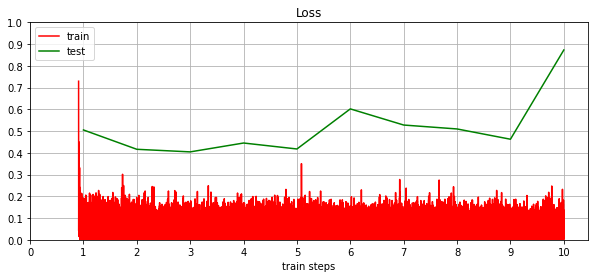

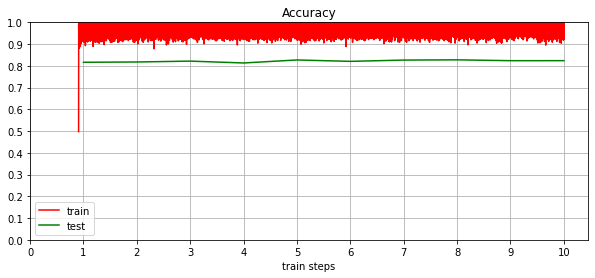

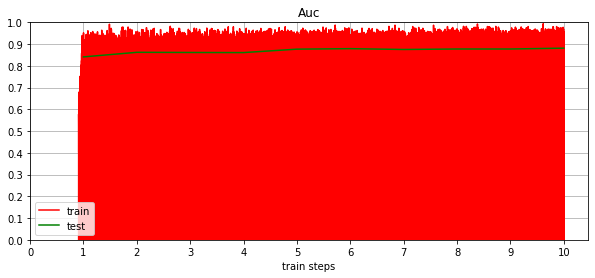

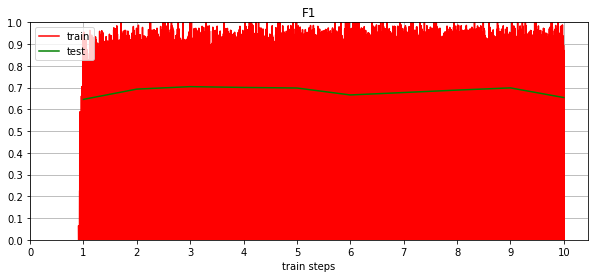

Time:  29109346.476981033
Epoch 10: ROC-AUC = 88.14%
Epoch 10: Precision = 0.743
Epoch 10: Recall = 0.588
Epoch 10: F1-score = 0.654
Final ROC-AUC = 88.14%
Final Precision = 0.743
Final Recall = 0.588
Final F1-score = 0.654


In [27]:
train_auc_log, train_pr_log, train_rec_log, train_f1_log, train_acc_log, train_loss_log = [], [], [], [], [], []
val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log = [], [], [], [], [], []
times = []
best_models = []

train(model, opt, 10)

In [28]:
print("Epoch {}".format(np.argmax(val_f1_log)))
print("Max F1-score: {:.4f}%".format(val_f1_log[np.argmax(val_f1_log)]*100))
print("ROC-AUC: {:.4f}%".format(val_auc_log[np.argmax(val_f1_log)]*100))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

Epoch 2
Max F1-score: 70.4337%
ROC-AUC: 86.1494%
Precision: 0.6688
Recall: 0.7468
Mean time for 1 epoch 130.92 minutes


In [29]:
torch.save(best_models[np.argmax(val_f1_log)].state_dict(), 
           './models/cnn_g4_model_optuned_10layers.pt')

# No dilations + SELU for linear

In [17]:
class DeepCNN_OptunaTuned(nn.Module):
    def __init__(self, width):
        super().__init__()
        self.width = width
        self.conv_layers = self._build_conv()
        self.flattened_size = self._get_flattened_size()
        self.fc_layers = self._build_fc()

    def _build_conv(self):
        n_layers = 10
        layers = []
        
        kernel_size = 3
        activation_layer = nn.LeakyReLU()
        channels_number = [1, 4, 32, 256, 512, 512, 64, 16, 2, 1, 1]
        strides = [1, 1, 1, 2, 1, 1, 1, 1, 1, 2]
        
        for i in range(n_layers):
            layers.extend([
                nn.Conv2d(
                    channels_number[i], 
                    channels_number[i+1], 
                    kernel_size, 
                    stride=strides[i],
                    padding=1
                ),
                nn.BatchNorm2d(channels_number[i+1]),
                activation_layer
            ])
            
            
        return nn.Sequential(*layers)

    def _get_flattened_size(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, self.width, len(feature_names) + 4)
            dummy_output = self.conv_layers(dummy_input)
            return dummy_output.shape[2] * dummy_output.shape[3]
        
    def _build_fc(self):
        linear_size = 1200
        return nn.Sequential(
            nn.AlphaDropout(p=0.4),
            nn.Flatten(-2, -1),
            nn.Linear(self.flattened_size, linear_size),
            nn.AlphaDropout(p=0.45),
            nn.SELU(),
            nn.Linear(linear_size, self.width * 2),
            nn.Unflatten(-1, (self.width, 2)),
        )

    def forward(self, x):
        batch = x.shape[0]
        x = x.reshape(batch, 1, self.width, len(feature_names) + 4)
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        x = torch.squeeze(x)
        return F.log_softmax(x, dim=-1)

In [ ]:
width = 100
loader_train, loader_test = get_train_test_data(width)

In [43]:
set_random_seed(42)
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with torch.cuda.device(device):
    model = DeepCNN_OptunaTuned(width)
    model = nn.DataParallel(model)
    model = model.to(device)

opt = optim.AdamW(model.parameters(), lr=2*1e-4, weight_decay=5*1e-5)

gc.collect()

27623

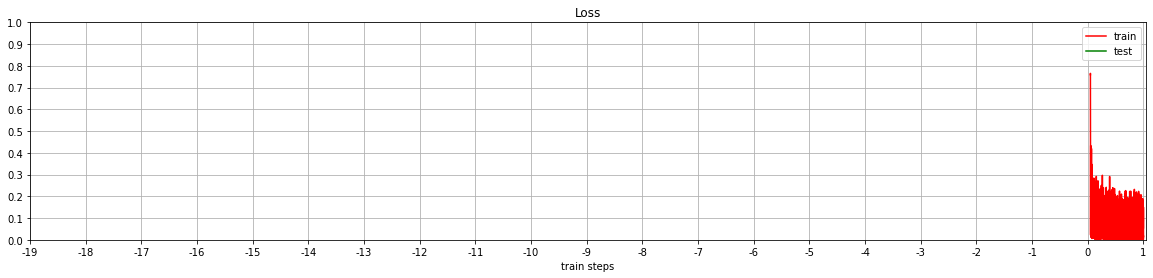

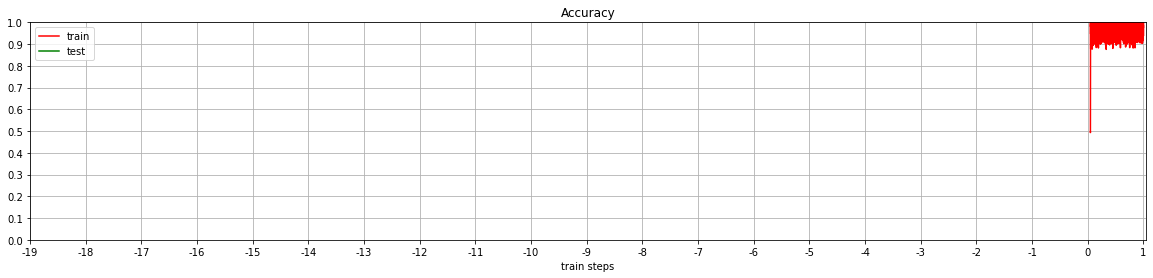

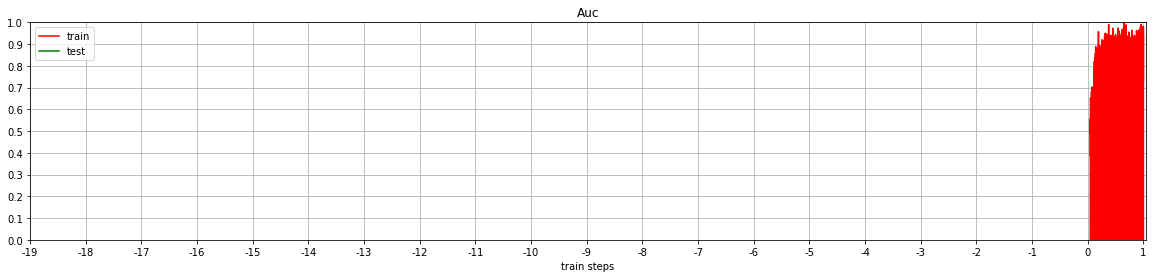

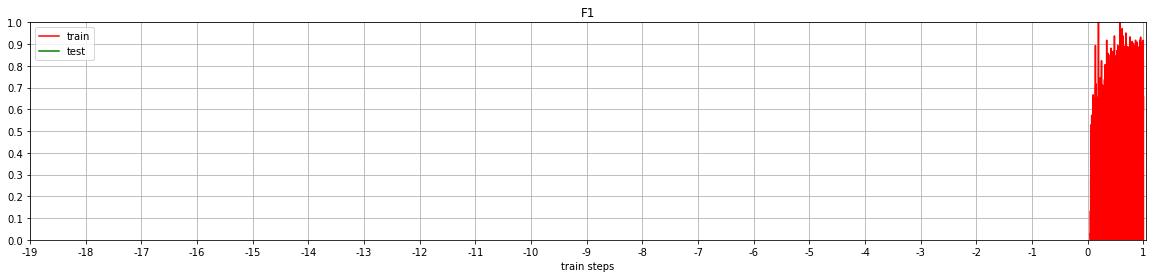

Time:  29068498.632821012
Epoch 1: ROC-AUC = 80.22%
Epoch 1: Precision = 0.651
Epoch 1: Recall = 0.305
Epoch 1: F1-score = 0.412
Epoch 2 of 7


KeyboardInterrupt: 

In [44]:
train_auc_log, train_pr_log, train_rec_log, train_f1_log, train_acc_log, train_loss_log = [], [], [], [], [], []
val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log = [], [], [], [], [], []
times = []
best_models = []

train(model, opt, 7)

# 8 layers + residual connections every 2 layers + add scheduler

In [ ]:
class DeepCNN_OptunaTuned(nn.Module):
    def __init__(self, width):
        super().__init__()
        self.width = width
        self.conv_layers = self._build_conv()
        self.flattened_size = self._get_flattened_size()
        self.fc_layers = self._build_fc()

    def _build_conv(self):
        n_layers = 8
        layers = []
        
        kernel_size = 3
        activation_layer = nn.LeakyReLU()
        channels_number = [1, 4, 32, 256, 512, 128, 16, 4, 1]
        dilations = [3, 2, 1, 1, 2, 2, 2, 3]
        strides = [1, 1, 1, 2, 1, 1, 1, 1]
        
        for i in range(1, n_layers, 2):
            block = ResidualConvBlock(
                channels_number=[channels_number[i-1], channels_number[i], channels_number[i+1]],
                kernel_size=kernel_size,
                strides=[strides[i-1], strides[i]],
                dilations=[dilations[i-1], dilations[i]],
                activation=activation_layer
            )
            layers.append(block)
            
        return nn.Sequential(*layers)

    def _get_flattened_size(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, self.width, len(feature_names) + 4)
            dummy_output = self.conv_layers(dummy_input)
            return dummy_output.shape[2] * dummy_output.shape[3]
        
    def _build_fc(self):
        linear_size = 1200
        return nn.Sequential(
            nn.AlphaDropout(p=0.4),
            nn.Flatten(-2, -1),
            nn.Linear(self.flattened_size, linear_size),
            nn.AlphaDropout(p=0.45),
            nn.ReLU(),
            nn.Linear(linear_size, self.width * 2),
            nn.Unflatten(-1, (self.width, 2)),
        )

    def forward(self, x):
        batch = x.shape[0]
        x = x.reshape(batch, 1, self.width, len(feature_names) + 4)
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        x = torch.squeeze(x)
        return F.log_softmax(x, dim=-1)
    
class ResidualConvBlock(nn.Module):
    def __init__(self, channels_number, kernel_size, strides, dilations, activation):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels_number[0], channels_number[1], kernel_size, 
                      stride=strides[0], dilation=dilations[0], padding=(kernel_size - 1) * dilations[0] // 2),
            nn.BatchNorm2d(channels_number[1]),
            activation,
            nn.Conv2d(channels_number[1], channels_number[2], kernel_size, 
                      stride=strides[1], dilation=dilations[1], padding=(kernel_size - 1) * dilations[1] // 2),
            nn.BatchNorm2d(channels_number[2]),
            activation,
        )
        
        self.shortcut = nn.Conv2d(
            channels_number[0],
            channels_number[2],
            kernel_size=1,
            stride=strides[0] * strides[1],
            padding=0
        )

    def forward(self, x):
        out = self.conv(x) + self.shortcut(x)
        return out

In [ ]:
width = 100
loader_train, loader_test = get_train_test_data(width)

In [ ]:
set_random_seed(42)
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with torch.cuda.device(device):
    model = DeepCNN_OptunaTuned(width)
    model = nn.DataParallel(model)
    model = model.to(device)

opt = optim.AdamW(model.parameters(), lr=2*1e-4, weight_decay=5*1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, mode="max", patience=0, factor=0.2)

gc.collect()

45

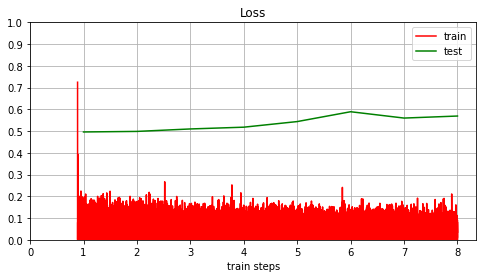

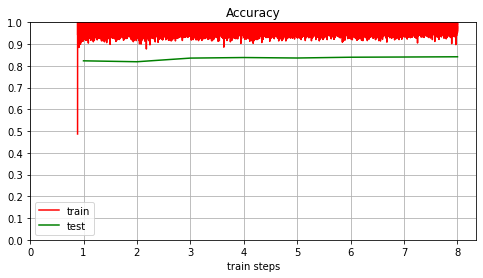

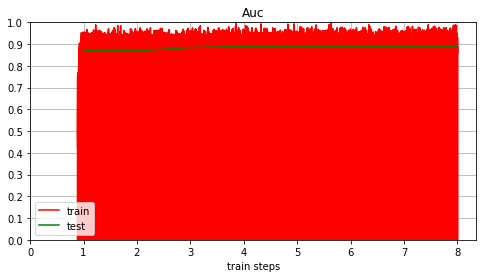

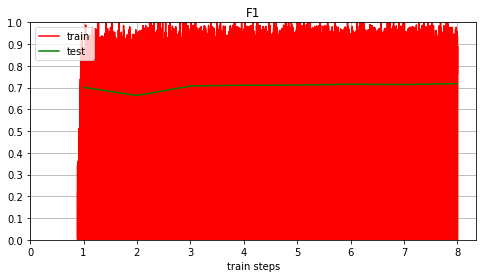

Time:  29072903.29833365
Epoch 8: ROC-AUC = 88.85%
Epoch 8: Precision = 0.729
Epoch 8: Recall = 0.711
Epoch 8: F1-score = 0.718
Final ROC-AUC = 88.85%
Final Precision = 0.729
Final Recall = 0.711
Final F1-score = 0.718


In [ ]:
train_auc_log, train_pr_log, train_rec_log, train_f1_log, train_acc_log, train_loss_log = [], [], [], [], [], []
val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log = [], [], [], [], [], []
times = []
best_models = []

train(model, opt, 8, scheduler)

In [100]:
print("Epoch {}".format(np.argmax(val_f1_log) + 1))
print("Max F1-score: {:.4f}%".format(val_f1_log[np.argmax(val_f1_log)]*100))
print("ROC-AUC: {:.4f}%".format(val_auc_log[np.argmax(val_f1_log)]*100))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

Epoch 8
Max F1-score: 71.8381%
ROC-AUC: 88.8515%
Precision: 0.7286
Recall: 0.7113
Mean time for 1 epoch 104.67 minutes


In [101]:
torch.save(best_models[np.argmax(val_f1_log)].state_dict(), 
           './models/cnn_g4_model_optuned_8layers.pt')

### Another bunch of epochs

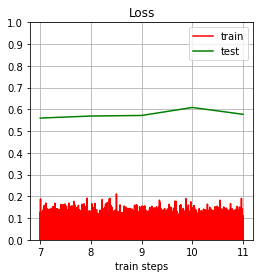

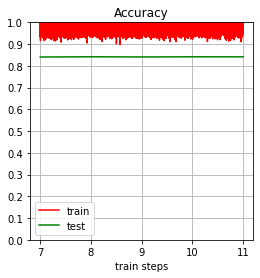

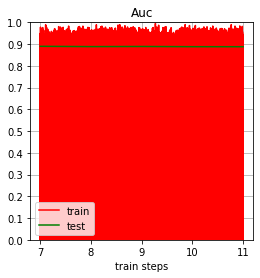

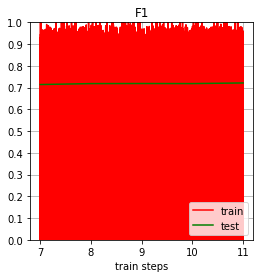

Time:  29073236.942576136
Epoch 3: ROC-AUC = 88.80%
Epoch 3: Precision = 0.723
Epoch 3: Recall = 0.723
Epoch 3: F1-score = 0.721
Epoch 4 of 4


In [ ]:
train(model, opt, 4, scheduler)

In [1]:
print("Epoch {}".format(np.argmax(val_f1_log) + 1))
print("Max F1-score: {:.4f}%".format(val_f1_log[np.argmax(val_f1_log)]*100))
print("ROC-AUC: {:.4f}%".format(val_auc_log[np.argmax(val_f1_log)]*100))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

Epoch 11
Max F1-score: 72.1329%
ROC-AUC: 88.8003%
Precision: 0.7228
Recall: 0.7227
Mean time for 1 epoch 104.77 minutes


In [ ]:
torch.save(best_models[np.argmax(val_f1_log)].state_dict(), 
           './models/cnn_g4_model_optuned_8layers_12epochs.pt')

# Adding dropout after convolutional layers

In [12]:
class DeepCNN_OptunaTuned(nn.Module):
    def __init__(self, width):
        super().__init__()
        self.width = width
        self.conv_layers = self._build_conv()
        self.flattened_size = self._get_flattened_size()
        self.fc_layers = self._build_fc()

    def _build_conv(self):
        n_layers = 8
        layers = []
        
        kernel_size = 3
        activation_layer = nn.LeakyReLU()
        channels_number = [1, 4, 32, 256, 512, 128, 16, 4, 1]
        dilations = [3, 2, 1, 1, 2, 2, 2, 3]
        strides = [1, 1, 1, 2, 1, 1, 1, 1]
        
        for i in range(1, n_layers, 2):
            block = ResidualConvBlock(
                channels_number=[channels_number[i-1], channels_number[i], channels_number[i+1]],
                kernel_size=kernel_size,
                strides=[strides[i-1], strides[i]],
                dilations=[dilations[i-1], dilations[i]],
                activation=activation_layer
            )
            layers.append(block)
            
        return nn.Sequential(*layers)

    def _get_flattened_size(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, self.width, len(feature_names) + 4)
            dummy_output = self.conv_layers(dummy_input)
            return dummy_output.shape[2] * dummy_output.shape[3]
        
    def _build_fc(self):
        linear_size = 1200
        return nn.Sequential(
            nn.Flatten(-2, -1),
            nn.Linear(self.flattened_size, linear_size),
            nn.Dropout(p=0.45),
            nn.ReLU(),
            nn.Linear(linear_size, self.width * 2),
            nn.Unflatten(-1, (self.width, 2)),
        )

    def forward(self, x):
        batch = x.shape[0]
        x = x.reshape(batch, 1, self.width, len(feature_names) + 4)
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        x = torch.squeeze(x)
        return F.log_softmax(x, dim=-1)

class ResidualConvBlock(nn.Module):
    def __init__(self, channels_number, kernel_size, strides, dilations, activation, dropout_p=0.1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels_number[0], channels_number[1], kernel_size, 
                      stride=strides[0], dilation=dilations[0], padding=(kernel_size - 1) * dilations[0] // 2),
            nn.BatchNorm2d(channels_number[1]),
            nn.Dropout2d(p=dropout_p),
            activation,
            
            nn.Conv2d(channels_number[1], channels_number[2], kernel_size, 
                      stride=strides[1], dilation=dilations[1], padding=(kernel_size - 1) * dilations[1] // 2),
            nn.BatchNorm2d(channels_number[2]),
            nn.Dropout2d(p=dropout_p),
            activation,
        )
        
        self.shortcut = nn.Conv2d(
            channels_number[0],
            channels_number[2],
            kernel_size=1,
            stride=strides[0] * strides[1],
            padding=0
        )

    def forward(self, x):
        out = self.conv(x) + self.shortcut(x)
        return out

In [ ]:
width = 100
loader_train, loader_test = get_train_test_data(width)

In [16]:
set_random_seed(42)
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with torch.cuda.device(device):
    model = DeepCNN_OptunaTuned(width)
    model = nn.DataParallel(model)
    model = model.to(device)

opt = optim.AdamW(model.parameters(), lr=2*1e-4, weight_decay=5*1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, mode="max", patience=0, factor=0.2)
gc.collect()

1042

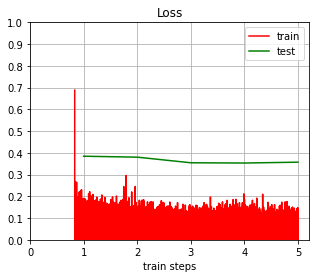

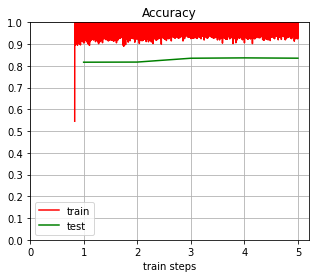

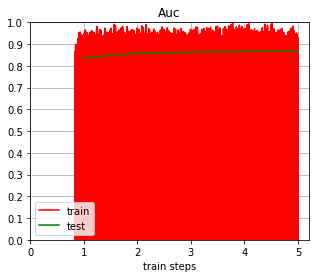

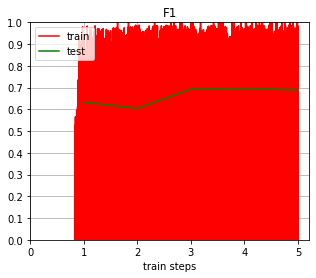

Time:  29079704.247886278
Epoch 5: ROC-AUC = 86.66%
Epoch 5: Precision = 0.745
Epoch 5: Recall = 0.644
Epoch 5: F1-score = 0.689
Final ROC-AUC = 86.66%
Final Precision = 0.745
Final Recall = 0.644
Final F1-score = 0.689


In [17]:
train_auc_log, train_pr_log, train_rec_log, train_f1_log, train_acc_log, train_loss_log = [], [], [], [], [], []
val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log = [], [], [], [], [], []
times = []
best_models = []

train(model, opt, 5, scheduler)

In [18]:
print("Epoch {}".format(np.argmax(val_f1_log) + 1))
print("Max F1-score: {:.4f}%".format(val_f1_log[np.argmax(val_f1_log)]*100))
print("ROC-AUC: {:.4f}%".format(val_auc_log[np.argmax(val_f1_log)]*100))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

Epoch 4
Max F1-score: 69.5477%
ROC-AUC: 86.6401%
Precision: 0.7410
Recall: 0.6582
Mean time for 1 epoch 107.09 minutes


# Reducing number of channels

In [ ]:
class DeepCNN_OptunaTuned(nn.Module):
    def __init__(self, width):
        super().__init__()
        self.width = width
        self.conv_layers = self._build_conv()
        self.flattened_size = self._get_flattened_size()
        self.fc_layers = self._build_fc()

    def _build_conv(self):
        n_layers = 8
        layers = []
        
        kernel_size = 3
        activation_layer = nn.LeakyReLU()
        channels_number = [1, 4, 16, 64, 128, 64, 16, 4, 1]
        dilations = [3, 2, 1, 1, 2, 2, 2, 3]
        strides = [1, 1, 1, 2, 1, 1, 1, 1]
        
        for i in range(n_layers):
            block = ResidualConvBlock(
                channels_number=[ channels_number[i], channels_number[i+1]],
                kernel_size=kernel_size,
                strides=[strides[i]],
                dilations=[dilations[i]],
                activation=activation_layer
            )
            layers.append(block)
            
        return nn.Sequential(*layers)

    def _get_flattened_size(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, self.width, len(feature_names) + 4)
            dummy_output = self.conv_layers(dummy_input)
            return dummy_output.shape[2] * dummy_output.shape[3]
        
    def _build_fc(self):
        linear_size = 2200
        return nn.Sequential(
            nn.Flatten(-2, -1),
            nn.AlphaDropout(p=0.1),
            nn.Linear(self.flattened_size, linear_size),
            nn.AlphaDropout(p=0.2),
            nn.ReLU(),
            nn.Linear(linear_size, self.width * 2),
            nn.Unflatten(-1, (self.width, 2)),
        )

    def forward(self, x):
        batch = x.shape[0]
        x = x.reshape(batch, 1, self.width, len(feature_names) + 4)
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        x = torch.squeeze(x)
        return F.log_softmax(x, dim=-1)

class ResidualConvBlock(nn.Module):
    def __init__(self, channels_number, kernel_size, strides, dilations, activation):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels_number[0], channels_number[1], kernel_size, 
                      stride=strides[0], dilation=dilations[0], padding=(kernel_size - 1) * dilations[0] // 2),
            nn.BatchNorm2d(channels_number[1]),
            activation,
        )
        
        self.shortcut = nn.Conv2d(
            channels_number[0],
            channels_number[1],
            kernel_size=1,
            stride=strides[0],
            padding=0
        )

    def forward(self, x):
        out = self.conv(x) + self.shortcut(x)
        return out

In [ ]:
width = 100
loader_train, loader_test = get_train_test_data(width)

In [30]:
set_random_seed(42)
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with torch.cuda.device(device):
    model = DeepCNN_OptunaTuned(width)
    model = nn.DataParallel(model)
    model = model.to(device)

opt = optim.AdamW(model.parameters(), lr=2*1e-4, weight_decay=5*1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, mode="max", patience=0, factor=0.2)
gc.collect()

19

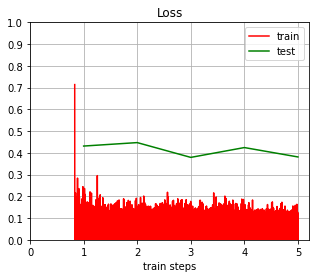

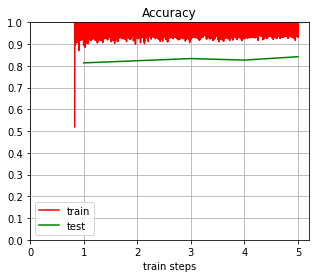

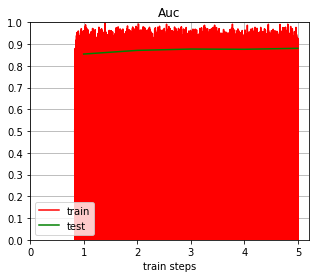

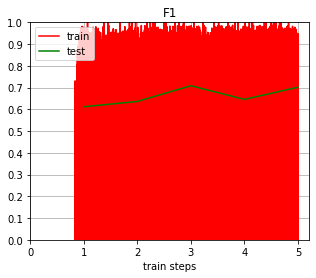

Time:  29081800.113844447
Epoch 5: ROC-AUC = 88.06%
Epoch 5: Precision = 0.759
Epoch 5: Recall = 0.655
Epoch 5: F1-score = 0.702
Final ROC-AUC = 88.06%
Final Precision = 0.759
Final Recall = 0.655
Final F1-score = 0.702


In [31]:
train_auc_log, train_pr_log, train_rec_log, train_f1_log, train_acc_log, train_loss_log = [], [], [], [], [], []
val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log = [], [], [], [], [], []
times = []
best_models = []

train(model, opt, 5, scheduler)

### Another bunch of epochs

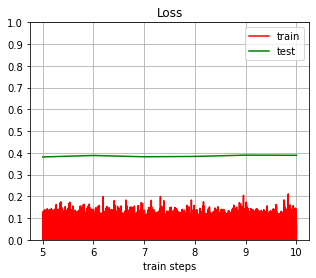

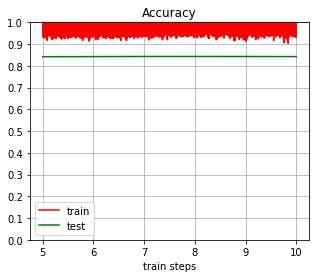

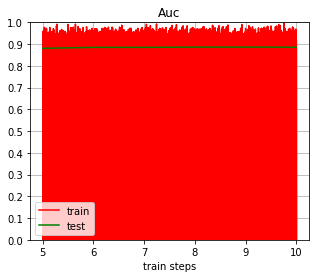

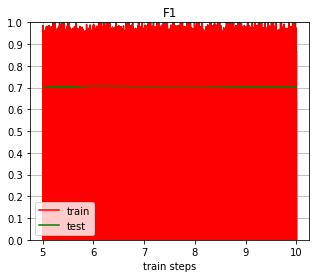

Time:  29082120.558044944
Epoch 5: ROC-AUC = 88.57%
Epoch 5: Precision = 0.752
Epoch 5: Recall = 0.67
Epoch 5: F1-score = 0.707
Final ROC-AUC = 88.57%
Final Precision = 0.752
Final Recall = 0.67
Final F1-score = 0.707


In [32]:
train(model, opt, 5, scheduler)

In [33]:
print("Epoch {}".format(np.argmax(val_f1_log) + 1))
print("Max F1-score: {:.4f}%".format(val_f1_log[np.argmax(val_f1_log)]*100))
print("ROC-AUC: {:.4f}%".format(val_auc_log[np.argmax(val_f1_log)]*100))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

Epoch 6
Max F1-score: 70.9869%
ROC-AUC: 88.5109%
Precision: 0.7470
Recall: 0.6793
Mean time for 1 epoch 61.76 minutes


In [34]:
torch.save(best_models[np.argmax(val_f1_log)].state_dict(), 
           './models/cnn_g4_model_optuned_10layers_reduced_channels.pt')

# Interval width experiments

In [17]:
class DeepCNN_OptunaTuned(nn.Module):
    def __init__(self, width):
        super().__init__()
        self.width = width
        self.conv_layers = self._build_conv()
        self.flattened_size = self._get_flattened_size()
        self.fc_layers = self._build_fc()

    def _build_conv(self):
        n_layers = 8
        layers = []
        
        kernel_size = 3
        activation_layer = nn.LeakyReLU()
        channels_number = [1, 4, 16, 64, 128, 64, 16, 4, 1]
        dilations = [3, 2, 1, 1, 2, 2, 2, 3]
        strides = [1, 1, 1, 2, 1, 1, 1, 1]
        
        for i in range(n_layers):
            block = ResidualConvBlock(
                channels_number=[channels_number[i], channels_number[i+1]],
                kernel_size=kernel_size,
                strides=[strides[i]],
                dilations=[dilations[i]],
                activation=activation_layer
            )
            layers.append(block)
            
        return nn.Sequential(*layers)

    def _get_flattened_size(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, self.width, len(feature_names) + 4)
            dummy_output = self.conv_layers(dummy_input)
            return dummy_output.shape[2] * dummy_output.shape[3]
        
    def _build_fc(self):
        linear_size = 2200
        return nn.Sequential(
            nn.Flatten(-2, -1),
            nn.AlphaDropout(p=0.1),
            nn.Linear(self.flattened_size, linear_size),
            nn.AlphaDropout(p=0.2),
            nn.ReLU(),
            nn.Linear(linear_size, self.width * 2),
            nn.Unflatten(-1, (self.width, 2)),
        )

    def forward(self, x):
        batch = x.shape[0]
        x = x.reshape(batch, 1, self.width, len(feature_names) + 4)
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        x = torch.squeeze(x)
        return F.log_softmax(x, dim=-1)

class ResidualConvBlock(nn.Module):
    def __init__(self, channels_number, kernel_size, strides, dilations, activation):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels_number[0], channels_number[1], kernel_size, 
                      stride=strides[0], dilation=dilations[0], padding=(kernel_size - 1) * dilations[0] // 2),
            nn.BatchNorm2d(channels_number[1]),
            activation,
        )
        
        self.shortcut = nn.Conv2d(
            channels_number[0],
            channels_number[1],
            kernel_size=1,
            stride=strides[0],
            padding=0
        )

    def forward(self, x):
        out = self.conv(x) + self.shortcut(x)
        return out

## Width 200

In [38]:
width = 200
loader_train, loader_test = get_train_test_data(width)

In [45]:
set_random_seed(42)
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with torch.cuda.device(device):
    model = DeepCNN_OptunaTuned(width)
    model = nn.DataParallel(model)
    model = model.to(device)

opt = optim.AdamW(model.parameters(), lr=2*1e-4, weight_decay=5*1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, mode="max", patience=0, factor=0.2)
gc.collect()

1492

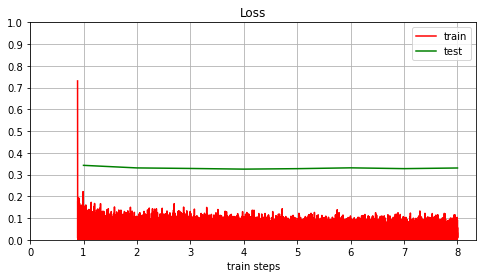

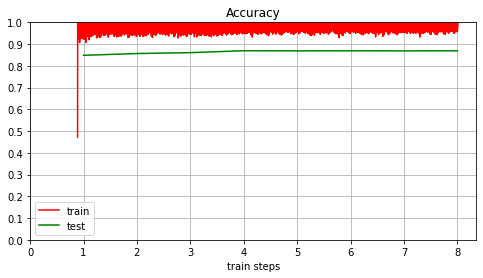

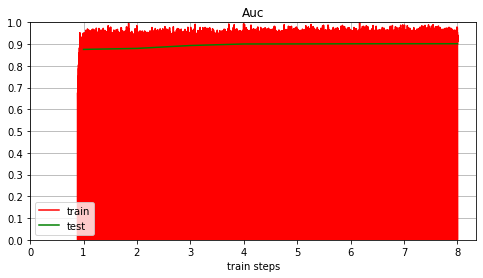

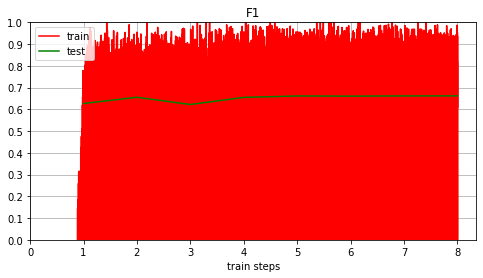

Time:  29082626.986966483
Epoch 8: ROC-AUC = 90.17%
Epoch 8: Precision = 0.698
Epoch 8: Recall = 0.632
Epoch 8: F1-score = 0.662
Final ROC-AUC = 90.17%
Final Precision = 0.698
Final Recall = 0.632
Final F1-score = 0.662


In [46]:
train_auc_log, train_pr_log, train_rec_log, train_f1_log, train_acc_log, train_loss_log = [], [], [], [], [], []
val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log = [], [], [], [], [], []
times = []
best_models = []

train(model, opt, 8, scheduler)

In [47]:
print("Epoch {}".format(np.argmax(val_f1_log) + 1))
print("Max F1-score: {:.4f}%".format(val_f1_log[np.argmax(val_f1_log)]*100))
print("ROC-AUC: {:.4f}%".format(val_auc_log[np.argmax(val_f1_log)]*100))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

Epoch 8
Max F1-score: 66.1866%
ROC-AUC: 90.1747%
Precision: 0.6984
Recall: 0.6317
Mean time for 1 epoch 60.11 minutes


In [48]:
torch.save(best_models[np.argmax(val_f1_log)].state_dict(), 
           './models/cnn_g4_model_optuned_8layers_reduced_channels_width_200.pt')

## Width 300

In [13]:
width = 300
loader_train, loader_test = get_train_test_data(width)

In [19]:
set_random_seed(42)
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with torch.cuda.device(device):
    model = DeepCNN_OptunaTuned(width)
    model = nn.DataParallel(model)
    model = model.to(device)

opt = optim.AdamW(model.parameters(), lr=2*1e-4, weight_decay=5*1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, mode="max", patience=0, factor=0.2)
gc.collect()

1127

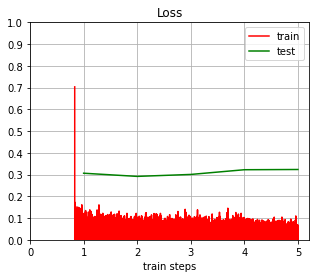

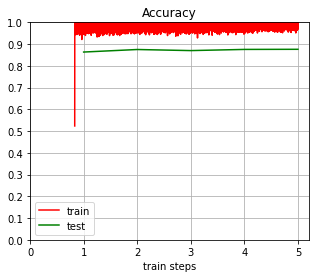

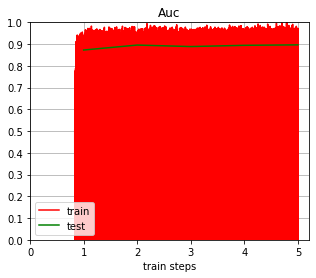

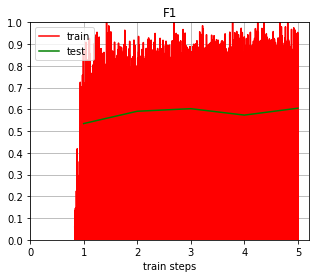

Time:  29083756.894984577
Epoch 5: ROC-AUC = 89.65%
Epoch 5: Precision = 0.652
Epoch 5: Recall = 0.568
Epoch 5: F1-score = 0.605
Final ROC-AUC = 89.65%
Final Precision = 0.652
Final Recall = 0.568
Final F1-score = 0.605


In [20]:
train_auc_log, train_pr_log, train_rec_log, train_f1_log, train_acc_log, train_loss_log = [], [], [], [], [], []
val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log = [], [], [], [], [], []
times = []
best_models = []

train(model, opt, 5, scheduler)

In [21]:
print("Epoch {}".format(np.argmax(val_f1_log) + 1))
print("Max F1-score: {:.4f}%".format(val_f1_log[np.argmax(val_f1_log)]*100))
print("ROC-AUC: {:.4f}%".format(val_auc_log[np.argmax(val_f1_log)]*100))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

Epoch 5
Max F1-score: 60.5238%
ROC-AUC: 89.6495%
Precision: 0.6521
Recall: 0.5676
Mean time for 1 epoch 59.39 minutes


In [22]:
torch.save(best_models[np.argmax(val_f1_log)].state_dict(), 
           './models/cnn_g4_model_optuned_8layers_reduced_channels_width_300.pt')

## Width 75

In [18]:
width = 75
loader_train, loader_test = get_train_test_data(width)

In [19]:
set_random_seed(42)
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with torch.cuda.device(device):
    model = DeepCNN_OptunaTuned(width)
    model = nn.DataParallel(model)
    model = model.to(device)

opt = optim.AdamW(model.parameters(), lr=2*1e-4, weight_decay=5*1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, mode="max", patience=0, factor=0.2)
gc.collect()

0

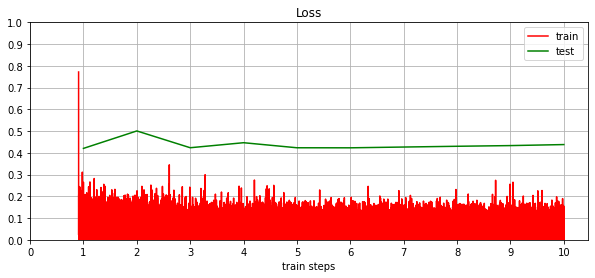

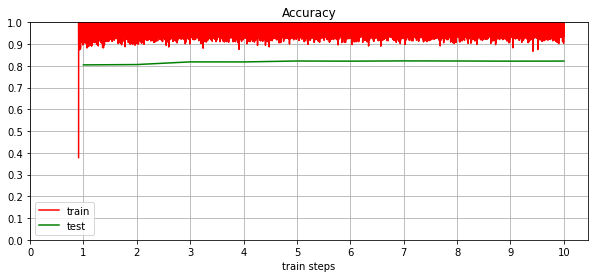

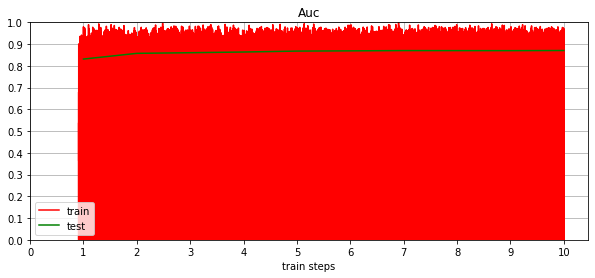

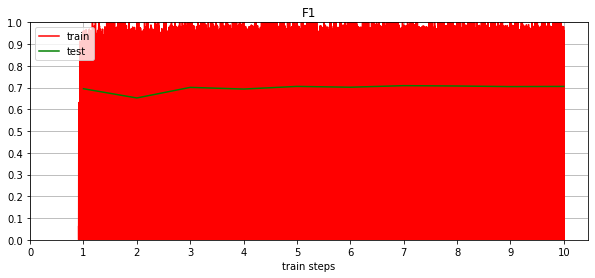

Time:  29114268.249264177
Epoch 10: ROC-AUC = 87.05%
Epoch 10: Precision = 0.768
Epoch 10: Recall = 0.656
Epoch 10: F1-score = 0.705
Final ROC-AUC = 87.05%
Final Precision = 0.768
Final Recall = 0.656
Final F1-score = 0.705


In [20]:
train_auc_log, train_pr_log, train_rec_log, train_f1_log, train_acc_log, train_loss_log = [], [], [], [], [], []
val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log = [], [], [], [], [], []
times = []
best_models = []

train(model, opt, 10, scheduler)

In [21]:
print("Epoch {}".format(np.argmax(val_f1_log) + 1))
print("Max F1-score: {:.4f}%".format(val_f1_log[np.argmax(val_f1_log)]*100))
print("ROC-AUC: {:.4f}%".format(val_auc_log[np.argmax(val_f1_log)]*100))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

Epoch 7
Max F1-score: 70.8900%
ROC-AUC: 87.0226%
Precision: 0.7651
Recall: 0.6636
Mean time for 1 epoch 63.20 minutes


In [22]:
torch.save(best_models[np.argmax(val_f1_log)].state_dict(), 
           './models/cnn_g4_model_optuned_8layers_reduced_channels_width_75.pt')

## Width 50

In [50]:
width = 50
loader_train, loader_test = get_train_test_data(width)

In [56]:
set_random_seed(42)
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with torch.cuda.device(device):
    model = DeepCNN_OptunaTuned(width)
    model = nn.DataParallel(model)
    model = model.to(device)

opt = optim.AdamW(model.parameters(), lr=2*1e-4, weight_decay=5*1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, mode="max", patience=0, factor=0.2)
gc.collect()

1869

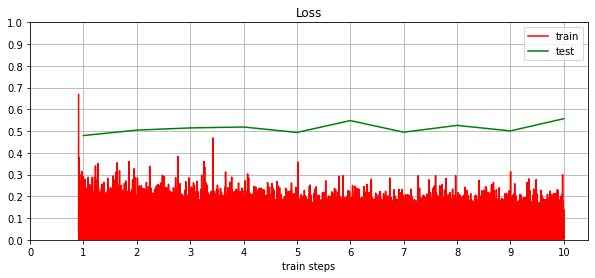

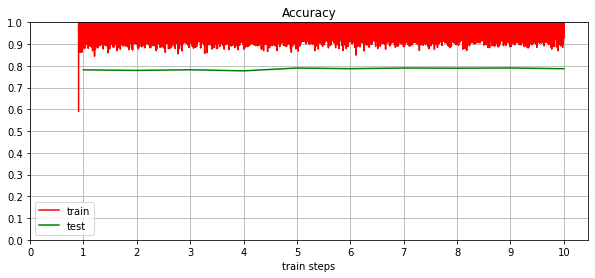

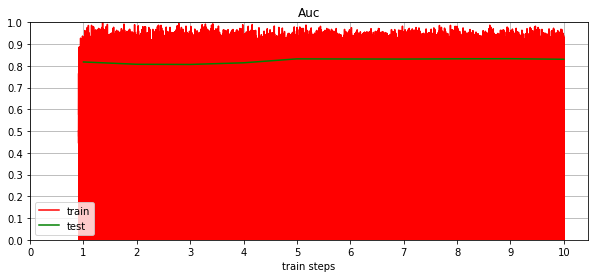

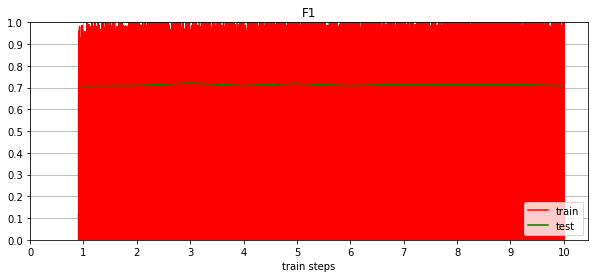

Time:  29092780.03535659
Epoch 10: ROC-AUC = 83.02%
Epoch 10: Precision = 0.77
Epoch 10: Recall = 0.66
Epoch 10: F1-score = 0.709
Final ROC-AUC = 83.02%
Final Precision = 0.77
Final Recall = 0.66
Final F1-score = 0.709


In [57]:
train_auc_log, train_pr_log, train_rec_log, train_f1_log, train_acc_log, train_loss_log = [], [], [], [], [], []
val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log = [], [], [], [], [], []
times = []
best_models = []

train(model, opt, 10, scheduler)

In [59]:
print("Epoch {}".format(np.argmax(val_f1_log) + 1))
print("Max F1-score: {:.4f}%".format(val_f1_log[np.argmax(val_f1_log)]*100))
print("ROC-AUC: {:.4f}%".format(val_auc_log[np.argmax(val_f1_log)]*100))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

Epoch 3
Max F1-score: 72.1447%
ROC-AUC: 80.6476%
Precision: 0.7295
Recall: 0.7171
Mean time for 1 epoch 62.49 minutes


In [60]:
torch.save(best_models[np.argmax(val_f1_log)].state_dict(), 
           './models/cnn_g4_model_optuned_8layers_reduced_channels_width_50.pt')

## Width 30

In [26]:
width = 30
loader_train, loader_test = get_train_test_data(width)

In [27]:
set_random_seed(42)
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with torch.cuda.device(device):
    model = DeepCNN_OptunaTuned(width)
    model = nn.DataParallel(model)
    model = model.to(device)

opt = optim.AdamW(model.parameters(), lr=2*1e-4, weight_decay=5*1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, mode="max", patience=0, factor=0.2)
gc.collect()

0

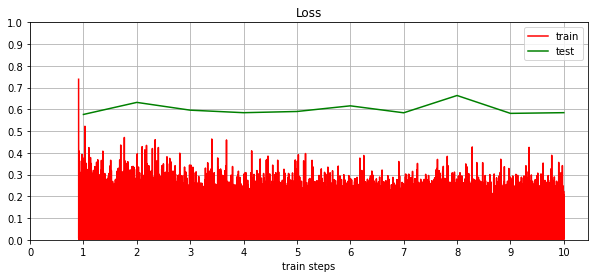

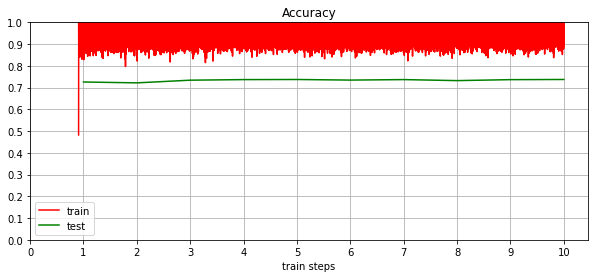

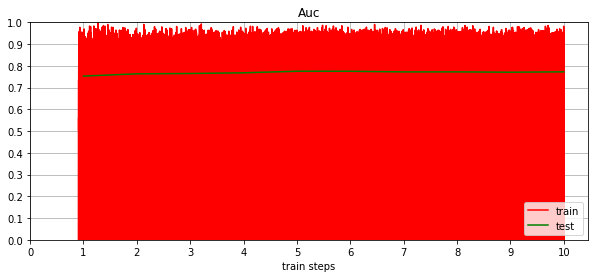

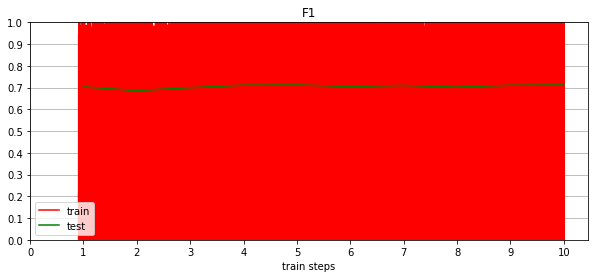

Time:  29096179.986971762
Epoch 10: ROC-AUC = 77.25%
Epoch 10: Precision = 0.771
Epoch 10: Recall = 0.667
Epoch 10: F1-score = 0.712
Final ROC-AUC = 77.25%
Final Precision = 0.771
Final Recall = 0.667
Final F1-score = 0.712


In [28]:
train_auc_log, train_pr_log, train_rec_log, train_f1_log, train_acc_log, train_loss_log = [], [], [], [], [], []
val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log = [], [], [], [], [], []
times = []
best_models = []

train(model, opt, 10, scheduler)

In [29]:
print("Epoch {}".format(np.argmax(val_f1_log) + 1))
print("Max F1-score: {:.4f}%".format(val_f1_log[np.argmax(val_f1_log)]*100))
print("ROC-AUC: {:.4f}%".format(val_auc_log[np.argmax(val_f1_log)]*100))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

Epoch 10
Max F1-score: 71.2298%
ROC-AUC: 77.2474%
Precision: 0.7706
Recall: 0.6671
Mean time for 1 epoch 78.67 minutes


In [30]:
torch.save(best_models[np.argmax(val_f1_log)].state_dict(), 
           './models/cnn_g4_model_optuned_8layers_reduced_channels_width_30.pt')

# Experimenting with omics encoding

In [ ]:
class DeepCNN_OptunaTuned(nn.Module):
    def __init__(self, width):
        super().__init__()
        self.width = width
        self.conv_layers = self._build_conv()
        self.flattened_size = self._get_flattened_size()
        self.fc_layers = self._build_fc()

    def _build_conv(self):
        n_layers = 8
        layers = []
        
        kernel_size = 3
        activation_layer = nn.LeakyReLU()
        channels_number = [1, 4, 16, 64, 128, 64, 16, 4, 1]
        dilations = [3, 2, 1, 1, 2, 2, 2, 3]
        strides = [1, 1, 1, 2, 1, 1, 1, 1]
        
        for i in range(n_layers):
            block = ResidualConvBlock(
                channels_number=[ channels_number[i], channels_number[i+1]],
                kernel_size=kernel_size,
                strides=[strides[i]],
                dilations=[dilations[i]],
                activation=activation_layer
            )
            layers.append(block)
            
        return nn.Sequential(*layers)

    def _get_flattened_size(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, self.width, len(feature_names) + 4)
            dummy_output = self.conv_layers(dummy_input)
            return dummy_output.shape[2] * dummy_output.shape[3]
        
    def _build_fc(self):
        linear_size = 2200
        return nn.Sequential(
            nn.Flatten(-2, -1),
            nn.AlphaDropout(p=0.1),
            nn.Linear(self.flattened_size, linear_size),
            nn.AlphaDropout(p=0.2),
            nn.ReLU(),
            nn.Linear(linear_size, self.width * 2),
            nn.Unflatten(-1, (self.width, 2)),
        )

    def forward(self, x):
        batch = x.shape[0]
        x = x.reshape(batch, 1, self.width, len(feature_names) + 4)
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        x = torch.squeeze(x)
        return F.log_softmax(x, dim=-1)

class ResidualConvBlock(nn.Module):
    def __init__(self, channels_number, kernel_size, strides, dilations, activation):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels_number[0], channels_number[1], kernel_size, 
                      stride=strides[0], dilation=dilations[0], padding=(kernel_size - 1) * dilations[0] // 2),
            nn.BatchNorm2d(channels_number[1]),
            activation,
        )
        
        self.shortcut = nn.Conv2d(
            channels_number[0],
            channels_number[1],
            kernel_size=1,
            stride=strides[0],
            padding=0
        )

    def forward(self, x):
        out = self.conv(x) + self.shortcut(x)
        return out

## Binarizing

In [29]:
width = 50
loader_train, loader_test = get_train_test_data(width, 1)

In [30]:
set_random_seed(42)
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with torch.cuda.device(device):
    model = DeepCNN_OptunaTuned(width)
    model = nn.DataParallel(model)
    model = model.to(device)

opt = optim.AdamW(model.parameters(), lr=2*1e-4, weight_decay=5*1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, mode="max", patience=0, factor=0.2)
gc.collect()

53

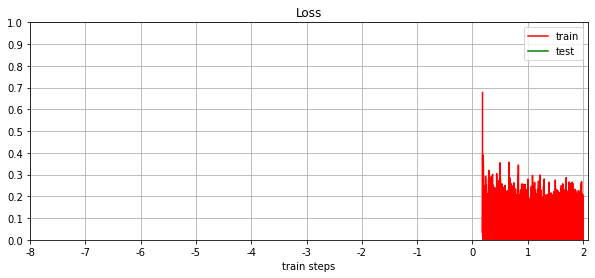

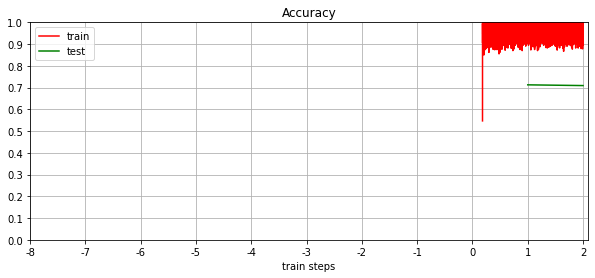

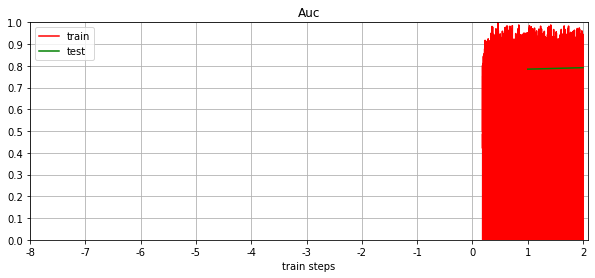

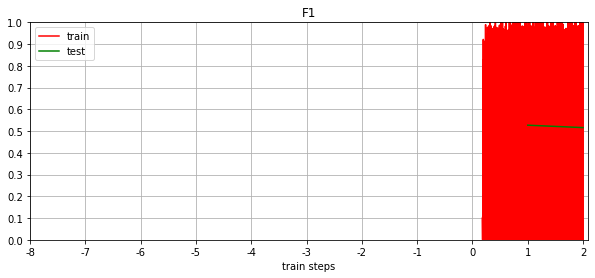

Time:  29098827.40185584
Epoch 2: ROC-AUC = 79.16%
Epoch 2: Precision = 0.753
Epoch 2: Recall = 0.399
Epoch 2: F1-score = 0.516
Epoch 3 of 10


KeyboardInterrupt: 

In [31]:
train_auc_log, train_pr_log, train_rec_log, train_f1_log, train_acc_log, train_loss_log = [], [], [], [], [], []
val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log = [], [], [], [], [], []
times = []
best_models = []

train(model, opt, 10, scheduler)

## Scaled by overall maximal value

In [12]:
feature_names = [i[:-4] for i in os.listdir('./data_hg_38/features/sparse_max_scaled/stem_cells') 
                 if i.endswith(".pkl") and not "G-quadruplex" in i]
DNA_features = {feature: load(f'./data_hg_38/features/sparse_max_scaled/stem_cells/{feature}.pkl')
                for feature in tqdm(feature_names)}

  0%|          | 0/321 [00:00<?, ?it/s]

In [18]:
width = 50
loader_train, loader_test = get_train_test_data(width, 5382)

In [19]:
set_random_seed(42)
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with torch.cuda.device(device):
    model = DeepCNN_OptunaTuned(width)
    model = nn.DataParallel(model)
    model = model.to(device)

opt = optim.AdamW(model.parameters(), lr=2*1e-4, weight_decay=5*1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, mode="max", patience=0, factor=0.2)
gc.collect()

0

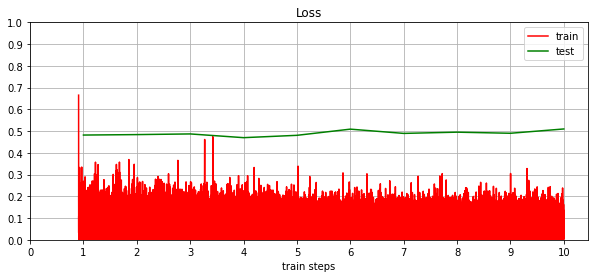

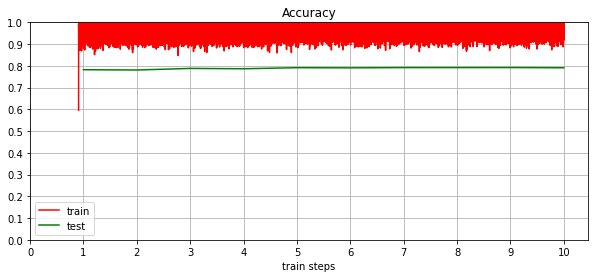

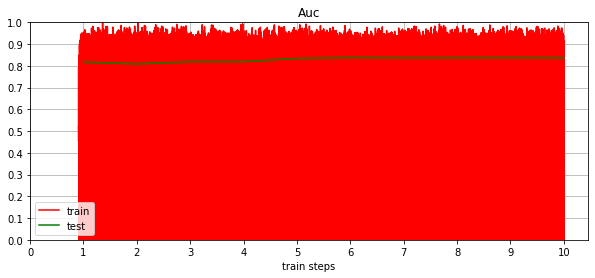

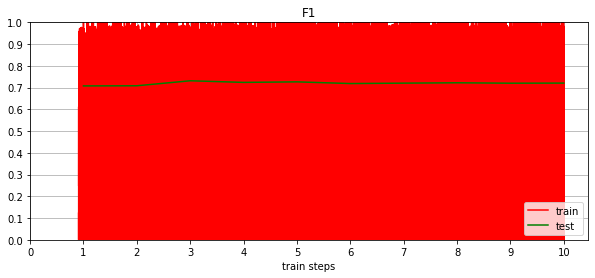

Time:  29095372.93847279
Epoch 10: ROC-AUC = 83.65%
Epoch 10: Precision = 0.765
Epoch 10: Recall = 0.685
Epoch 10: F1-score = 0.721
Final ROC-AUC = 83.65%
Final Precision = 0.765
Final Recall = 0.685
Final F1-score = 0.721


In [20]:
train_auc_log, train_pr_log, train_rec_log, train_f1_log, train_acc_log, train_loss_log = [], [], [], [], [], []
val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log = [], [], [], [], [], []
times = []
best_models = []

train(model, opt, 10, scheduler)

In [21]:
print("Epoch {}".format(np.argmax(val_f1_log) + 1))
print("Max F1-score: {:.4f}%".format(val_f1_log[np.argmax(val_f1_log)]*100))
print("ROC-AUC: {:.4f}%".format(val_auc_log[np.argmax(val_f1_log)]*100))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

Epoch 3
Max F1-score: 73.1377%
ROC-AUC: 81.9211%
Precision: 0.7340
Recall: 0.7322
Mean time for 1 epoch 66.83 minutes


In [22]:
torch.save(best_models[np.argmax(val_f1_log)].state_dict(), 
           './models/cnn_g4_model_optuned_8layers_less_channels_max_overall_scaled.pt')

## Scaled by max for every omics

In [14]:
feature_max_values = {}

for feature in feature_names:
    feature_data = DNA_features[feature]
    max_val = 0
    for chrom in chrom_names:
        if chrom in feature_data:
            max_val = feature_data[chrom].data.max()
    feature_max_values[feature] = max_val if max_val > 0 else 1.0

In [15]:
class Dataset(data.Dataset):
    def __init__(self, chroms, features,
                 dna_source, features_source,
                 labels_source, intervals, max_omics_value=1000):
        self.chroms = chroms
        self.features = features
        self.dna_source = dna_source
        self.features_source = features_source
        self.labels_source = labels_source
        self.intervals = intervals
        self.le = LabelBinarizer().fit(np.array([["A"], ["C"], ["T"], ["G"]]))

    def __len__(self):
        return len(self.intervals)

    def __getitem__(self, index):
        interval = self.intervals[index]
        chrom = interval[0]
        begin = int(interval[1])
        end = int(interval[2])
        dna_OHE = self.le.transform(list(self.dna_source[chrom][begin:end].upper()))

        feature_matr = []
        for feature in self.features:
            source = self.features_source[feature]
            max_val = feature_max_values.get(feature, 1.0)
            if chrom in source:
                feature_data = source[chrom][begin:end] / max_val
                feature_matr.append(feature_data)
            else:
                feature_matr.append(np.zeros(end - begin, dtype=np.float32))

        if len(feature_matr) > 0:
            X = np.hstack((dna_OHE, np.array(feature_matr).T)).astype(np.float32)
        else:
            X = dna_OHE.astype(np.float32)

        y = self.labels_source[interval[0]][interval[1]: interval[2]]
        return (X, y)

In [16]:
width = 50
loader_train, loader_test = get_train_test_data(width)

In [17]:
set_random_seed(42)
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with torch.cuda.device(device):
    model = DeepCNN_OptunaTuned(width)
    model = nn.DataParallel(model)
    model = model.to(device)

opt = optim.AdamW(model.parameters(), lr=2*1e-4, weight_decay=5*1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, mode="max", patience=0, factor=0.2)
gc.collect()

34

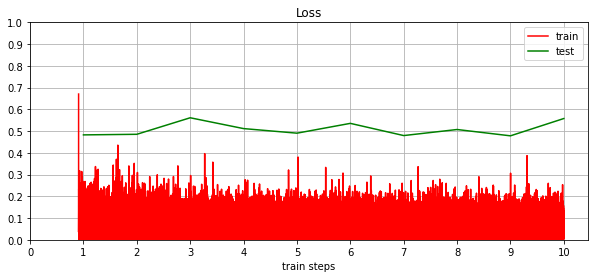

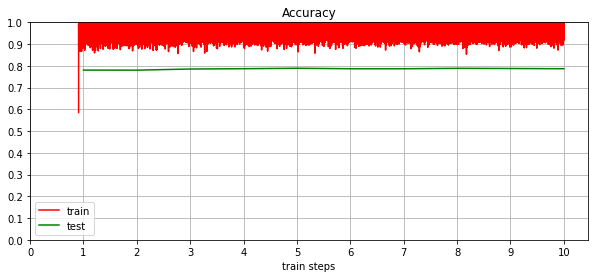

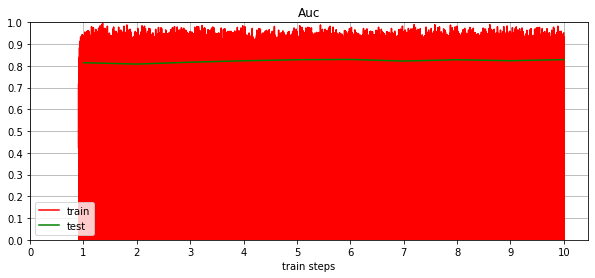

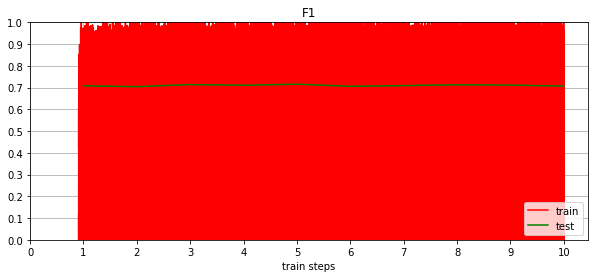

Time:  29098000.03760559
Epoch 10: ROC-AUC = 82.86%
Epoch 10: Precision = 0.774
Epoch 10: Recall = 0.654
Epoch 10: F1-score = 0.707
Final ROC-AUC = 82.86%
Final Precision = 0.774
Final Recall = 0.654
Final F1-score = 0.707


In [18]:
train_auc_log, train_pr_log, train_rec_log, train_f1_log, train_acc_log, train_loss_log = [], [], [], [], [], []
val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log = [], [], [], [], [], []
times = []
best_models = []

train(model, opt, 10, scheduler)

In [19]:
print("Epoch {}".format(np.argmax(val_f1_log) + 1))
print("Max F1-score: {:.4f}%".format(val_f1_log[np.argmax(val_f1_log)]*100))
print("ROC-AUC: {:.4f}%".format(val_auc_log[np.argmax(val_f1_log)]*100))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

Epoch 5
Max F1-score: 71.5657%
ROC-AUC: 82.8221%
Precision: 0.7659
Recall: 0.6752
Mean time for 1 epoch 66.30 minutes


In [20]:
torch.save(best_models[np.argmax(val_f1_log)].state_dict(), 
           './models/cnn_g4_model_optuned_8layers_reduced_channels_max_each_scaled.pt')

## Scale each omics by mean and variance

In [21]:
feature_mean_var = {}
total_len = sum(len(chrom_reader(chrom)) for chrom in chrom_names)

for feature in feature_names:
    feature_data = DNA_features[feature]
    
    total_sum = 0.0
    total_sq_sum = 0.0

    for vec in feature_data.values():
        values = vec.data
        indices = vec.indices
        shape = vec.shape

        segment_lengths = np.empty_like(values)
        segment_lengths[:-1] = indices[1:] - indices[:-1]
        segment_lengths[-1] = shape - indices[-1]

        total_sum += np.sum(values * segment_lengths)
        total_sq_sum += np.sum((values ** 2) * segment_lengths)

    mean = total_sum / total_len
    var = total_sq_sum / total_len - mean ** 2
    std = np.sqrt(var) if var > 1e-8 else 1.0
    
    feature_mean_var[feature] = [mean, std]

In [22]:
class Dataset(data.Dataset):
    def __init__(self, chroms, features,
                 dna_source, features_source,
                 labels_source, intervals, max_omics_value=1000):
        self.chroms = chroms
        self.features = features
        self.dna_source = dna_source
        self.features_source = features_source
        self.labels_source = labels_source
        self.intervals = intervals
        self.le = LabelBinarizer().fit(np.array([["A"], ["C"], ["T"], ["G"]]))

    def __len__(self):
        return len(self.intervals)

    def __getitem__(self, index):
        interval = self.intervals[index]
        chrom = interval[0]
        begin = int(interval[1])
        end = int(interval[2])
        dna_OHE = self.le.transform(list(self.dna_source[chrom][begin:end].upper()))

        feature_matr = []
        for feature in self.features:
            source = self.features_source[feature]
            mean = feature_mean_var.get(feature)[0]
            var = feature_mean_var.get(feature)[1]
            if chrom in source:
                feature_data = (source[chrom][begin:end] - mean) / var
            else:
                feature_data = (np.zeros(end - begin, dtype=np.float32) - mean) / var
            feature_matr.append(feature_data)

        if len(feature_matr) > 0:
            X = np.hstack((dna_OHE, np.array(feature_matr).T)).astype(np.float32)
        else:
            X = dna_OHE.astype(np.float32)

        y = self.labels_source[interval[0]][interval[1]: interval[2]]
        return (X, y)

In [23]:
width = 50
loader_train, loader_test = get_train_test_data(width)

In [24]:
set_random_seed(42)
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with torch.cuda.device(device):
    model = DeepCNN_OptunaTuned(width)
    model = nn.DataParallel(model)
    model = model.to(device)

opt = optim.AdamW(model.parameters(), lr=2*1e-4, weight_decay=5*1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, mode="max", patience=0, factor=0.2)
gc.collect()

51

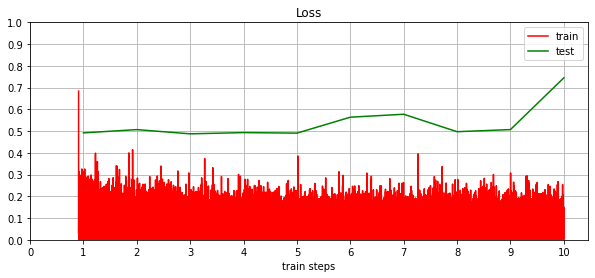

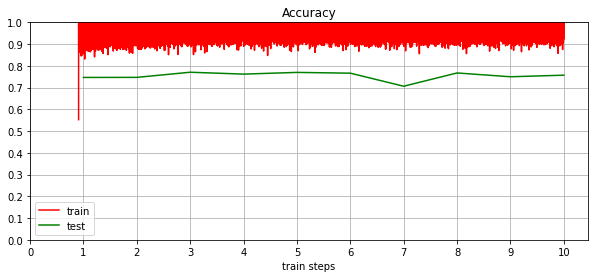

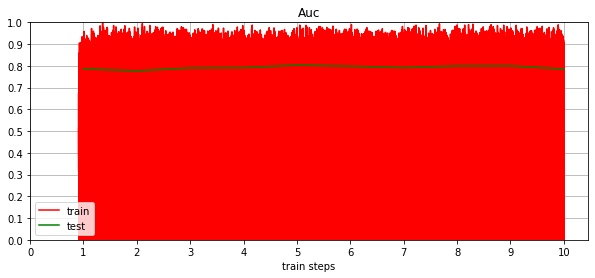

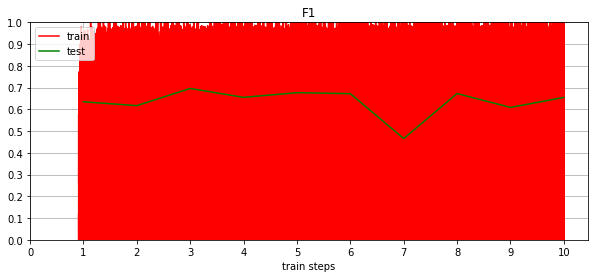

Time:  29098686.19911538
Epoch 10: ROC-AUC = 78.50%
Epoch 10: Precision = 0.747
Epoch 10: Recall = 0.587
Epoch 10: F1-score = 0.655
Final ROC-AUC = 78.5%
Final Precision = 0.747
Final Recall = 0.587
Final F1-score = 0.655


In [25]:
train_auc_log, train_pr_log, train_rec_log, train_f1_log, train_acc_log, train_loss_log = [], [], [], [], [], []
val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log = [], [], [], [], [], []
times = []
best_models = []

train(model, opt, 10, scheduler)

In [40]:
print("Epoch {}".format(np.argmax(val_f1_log) + 1))
print("Max F1-score: {:.4f}%".format(val_f1_log[np.argmax(val_f1_log)]*100))
print("ROC-AUC: {:.4f}%".format(val_auc_log[np.argmax(val_f1_log)]*100))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

Epoch 3
Max F1-score: 69.6321%
ROC-AUC: 79.0405%
Precision: 0.6771
Recall: 0.6964
Mean time for 1 epoch 63.51 minutes


# Train big model with best parameters

In [13]:
feature_names = [i[:-4] for i in os.listdir('./data_hg_38/features/sparse_max_scaled/stem_cells') 
                 if i.endswith(".pkl") and not "G-quadruplex" in i]
DNA_features = {feature: load(f'./data_hg_38/features/sparse_max_scaled/stem_cells/{feature}.pkl')
                for feature in tqdm(feature_names)}

  0%|          | 0/321 [00:00<?, ?it/s]

In [16]:
class DeepCNN_OptunaTuned(nn.Module):
    def __init__(self, width):
        super().__init__()
        self.width = width
        self.conv_layers = self._build_conv()
        self.flattened_size = self._get_flattened_size()
        self.fc_layers = self._build_fc()

    def _build_conv(self):
        n_layers = 8
        layers = []
        
        kernel_size = 3
        activation_layer = nn.LeakyReLU()
        
        channels_number = [1, 4, 32, 256, 512, 128, 16, 4, 1]
        dilations = [3, 2, 1, 1, 2, 2, 2, 3]
        strides = [1, 1, 1, 2, 1, 1, 1, 1]
        
        for i in range(1, n_layers, 2):
            block = ResidualConvBlock(
                channels_number=[channels_number[i-1], channels_number[i], channels_number[i+1]],
                kernel_size=kernel_size,
                strides=[strides[i-1], strides[i]],
                dilations=[dilations[i-1], dilations[i]],
                activation=activation_layer
            )
            layers.append(block)
            
        return nn.Sequential(*layers)

    def _get_flattened_size(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, self.width, len(feature_names) + 4)
            dummy_output = self.conv_layers(dummy_input)
            return dummy_output.shape[2] * dummy_output.shape[3]
        
    def _build_fc(self):
        linear_size = 1200
        return nn.Sequential(
            nn.AlphaDropout(p=0.4),
            nn.Flatten(-2, -1),
            nn.Linear(self.flattened_size, linear_size),
            nn.AlphaDropout(p=0.45),
            nn.ReLU(),
            nn.Linear(linear_size, self.width * 2),
            nn.Unflatten(-1, (self.width, 2)),
        )

    def forward(self, x):
        batch = x.shape[0]
        x = x.reshape(batch, 1, self.width, len(feature_names) + 4)
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        x = torch.squeeze(x)
        return F.log_softmax(x, dim=-1)
    
class ResidualConvBlock(nn.Module):
    def __init__(self, channels_number, kernel_size, strides, dilations, activation):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels_number[0], channels_number[1], kernel_size, 
                      stride=strides[0], dilation=dilations[0], padding=(kernel_size - 1) * dilations[0] // 2),
            nn.BatchNorm2d(channels_number[1]),
            activation,
            nn.Conv2d(channels_number[1], channels_number[2], kernel_size, 
                      stride=strides[1], dilation=dilations[1], padding=(kernel_size - 1) * dilations[1] // 2),
            nn.BatchNorm2d(channels_number[2]),
            activation,
        )
        
        self.shortcut = nn.Conv2d(
            channels_number[0],
            channels_number[2],
            kernel_size=1,
            stride=strides[0] * strides[1],
            padding=0
        )

    def forward(self, x):
        out = self.conv(x) + self.shortcut(x)
        return out

In [14]:
width = 50
loader_train, loader_test = get_train_test_data(width, 5382)

In [44]:
set_random_seed(42)
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with torch.cuda.device(device):
    model = DeepCNN_OptunaTuned(width)
    model = nn.DataParallel(model)
    model = model.to(device)

opt = optim.AdamW(model.parameters(), lr=2*1e-4, weight_decay=5*1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, mode="max", patience=0, factor=0.2)
gc.collect()

53

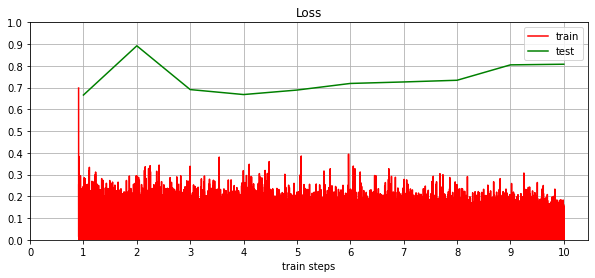

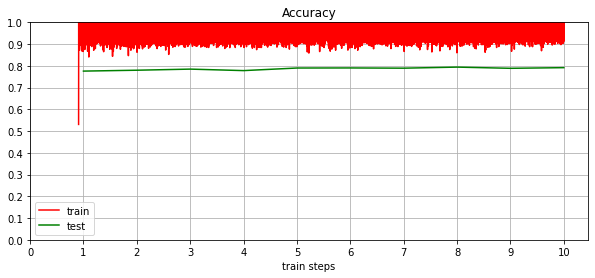

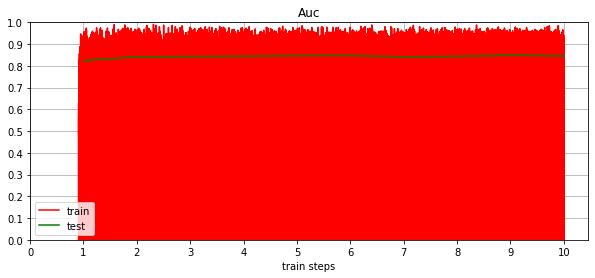

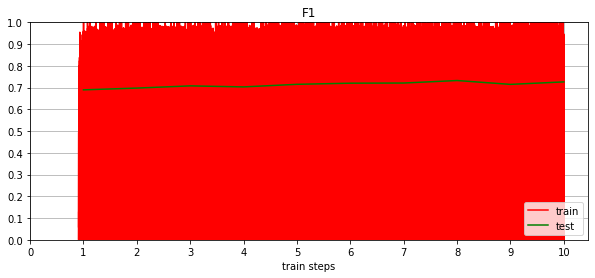

Time:  29100248.474003848
Epoch 10: ROC-AUC = 84.56%
Epoch 10: Precision = 0.756
Epoch 10: Recall = 0.702
Epoch 10: F1-score = 0.726
Final ROC-AUC = 84.56%
Final Precision = 0.756
Final Recall = 0.702
Final F1-score = 0.726


In [45]:
train_auc_log, train_pr_log, train_rec_log, train_f1_log, train_acc_log, train_loss_log = [], [], [], [], [], []
val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log = [], [], [], [], [], []
times = []
best_models = []

train(model, opt, 10, scheduler)

In [46]:
print("Epoch {}".format(np.argmax(val_f1_log) + 1))
print("Max F1-score: {:.4f}%".format(val_f1_log[np.argmax(val_f1_log)]*100))
print("ROC-AUC: {:.4f}%".format(val_auc_log[np.argmax(val_f1_log)]*100))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

Epoch 8
Max F1-score: 73.2501%
ROC-AUC: 84.3638%
Precision: 0.7540
Recall: 0.7155
Mean time for 1 epoch 98.01 minutes


### Another bunch of epochs

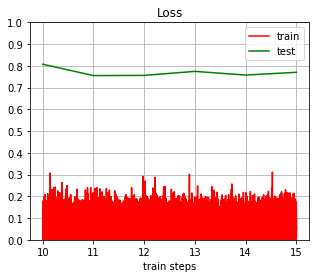

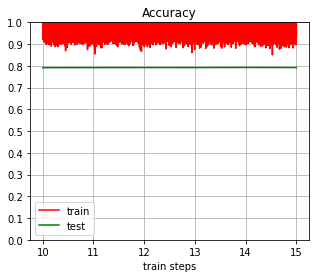

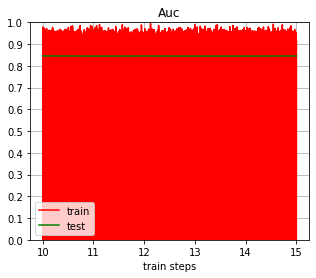

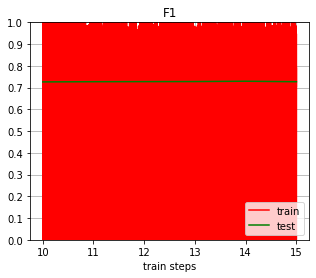

Time:  29100753.46515862
Epoch 5: ROC-AUC = 84.52%
Epoch 5: Precision = 0.756
Epoch 5: Recall = 0.703
Epoch 5: F1-score = 0.727
Final ROC-AUC = 84.52%
Final Precision = 0.756
Final Recall = 0.703
Final F1-score = 0.727


In [48]:
train(model, opt, 5, scheduler)

In [49]:
print("Epoch {}".format(np.argmax(val_f1_log) + 1))
print("Max F1-score: {:.4f}%".format(val_f1_log[np.argmax(val_f1_log)]*100))
print("ROC-AUC: {:.4f}%".format(val_auc_log[np.argmax(val_f1_log)]*100))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

Epoch 8
Max F1-score: 73.2501%
ROC-AUC: 84.3638%
Precision: 0.7540
Recall: 0.7155
Mean time for 1 epoch 98.98 minutes


In [50]:
torch.save(best_models[np.argmax(val_f1_log)].state_dict(), 
           './models/cnn_g4_best_model_width_50_max_overall_scaled.pt')